# Data Pipeline
Initial data analysis pipeline including a naive sentiment analysis using TextBlob.

In [1]:
import re
import html
import spacy
import textacy
from textblob import TextBlob
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import calmap # for making GitHub-style calendar plots of time-series
# Plot using Pandas datatime objects
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
rc_fonts = {'figure.figsize': (15, 8),
            'axes.labelsize': 20,
            'xtick.labelsize': 16,
            'ytick.labelsize': 16}
plt.rcParams.update(rc_fonts)
plt.style.use('ggplot')
%matplotlib inline

In [3]:
from string import punctuation
# Sciki-learn for TF-IDF and similarity detection
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS

## Use ```spaCy``` for tokenization and sentence segmentation

In [4]:
import spacy
from spacy import displacy
# Load spaCy language model (blank model to which we add pipeline components)
sentencizer = spacy.blank('en')
sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))

#### Specify named entity of interest

In [5]:
name = "Ryan Lochte"

In [6]:
datafile = 'all_the_news_v2.csv'
datapath = Path('../') / 'data' / datafile 
colnames = ['title', 'author', 'date', 'content', 'year', 'month', 'publication', 'length']

news = pd.read_csv(datapath, usecols=colnames, parse_dates=['date'])
news['author'] = news['author'].str.strip()
news.head()

,title,author,date,content,year,month,publication,length
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,2376
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,2125
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,3310
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,3632
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,262


In [7]:
news = news.dropna(subset=['date', 'title'])
news.shape[0]

143156

### Filter articles based on name match
In this section we only select those news articles that contain part of or all of the name we input as ```name```.

In [8]:
def check_name(content, name):
    flag = False
    if name in content:
        flag = True
    return flag

def filter_df(df):
    df['match'] = df['content'].apply(lambda x: check_name(x, name))
    df_relevant = df.loc[df['match'].eq(True)]
    return df_relevant.drop(['match'], axis=1)

news_relevant = filter_df(news)
print(news_relevant.shape[0])
news_relevant.head()

182


,title,author,date,content,year,month,publication,length
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614


### Perform sentence segmentation
Store the sentences in each news articles as a list of sentences, from which we can easily extract per-sentence sentiment.

In [9]:
def get_relevant(text, name):
    doc = sentencizer(text)
    relevant = []
    for sent in doc.sents:
        for n in name.split():
            if n in sent.text:
                clean = sent.text.replace("\n", " ").replace("\xa0", " ")
                # Strip bad characters at the start of sentences
                clean = clean.strip("[\'").strip("\']").strip('\"').strip("\'\"")
                clean = clean.strip(",\'").strip("\',").strip('\"').strip("\'\"").strip()
                relevant.append(clean)
    # Remove duplicates
    relevant = list(dict.fromkeys(relevant))
    return relevant

In [10]:
news_relevant['relevant'] = news_relevant['content'].apply(lambda x: get_relevant(x, name))

In [11]:
for i in news_relevant['relevant'][:5]:
    print(i, '\n--')

["That’s all Ryan Lochte wants as he ambles across the pool deck on a bright Southern California day, looking tanned and relaxed, if a bit weary from his morning workout.', '“", 'Lochte now finds himself living in Los Angeles with his pregnant fiancée and training at USC with thoughts of a comeback.', "Here’s the condensed version:', 'After a fifth-place finish in the 200-meter individual medley — his dissatisfaction hardly assuaged by a gold in the 800 freestyle relay — Lochte partied with three teammates at the French team’s hospitality house.',", "Lochte initially told authorities they were pulled over and robbed by armed men posing as police officers.',", "Lochte suffered an additional blow as Speedo and other corporate sponsors walked away.',", 'Ryan Lochte didn’t have to get drunk and vandalize a Rio de Janeiro gas station during the Summer Olympics in August.', "But he did, and it’s at times like this when people really need their...', 'Ryan Lochte didn’t have to get drunk and v

### Lemmatize relevant sentences for comparison
This is to remove duplicates.

In [12]:
# Load full spaCy language model for upcoming NLP pipeline
nlp = spacy.load('en_core_web_md')

In [13]:
add_removed_words = {n.lower() for n in name.split()}
# Include specific words to be removed
stopwords = nlp.Defaults.stop_words
stopwords = stopwords.union(add_removed_words)

In [14]:
# Tokenize and lemmatize text
def lemmatize(text):
    doc = sentencizer(text)
    lemmas = []
    for sentence in doc.sents:
        tokens = [str(tok.lemma_).lower() for tok in sentence if tok.text not in stopwords \
                  and tok.text not in punctuation]
        lemmas.append(' '.join(tokens))
    return lemmas

In [15]:
news_relevant['lemmas'] = news_relevant['relevant'].str.join(' ').apply(lemmatize)
news_relevant[['relevant', 'lemmas']].head()

,relevant,lemmas
3095,[That’s all Ryan Lochte wants as he ambles acr...,[that ’s ryan lochte want amble pool deck brig...
8946,"[Ryan Lochte, another preeminent American swim...",[ryan lochte preeminent american swimmer finis...
13789,[Ryan Held and Nathan Adrian brought the U.S. ...,[ryan held nathan adrian bring u.s. home adria...
13825,[Michael Phelps won the 200 individual medley ...,[michael phelps win 200 individual medley easi...
13839,[Phelps Breaks an Ancient Record: Michael Phel...,[phelps breaks ancient record michael phelps w...


### Drop duplicates

In [16]:
news_relevant['lemmas_combined'] = news_relevant['lemmas'].str.join(' ')
news_relevant = news_relevant.drop_duplicates(subset=['lemmas_combined'])
news_relevant.shape[0]

161

### Naive sentiment scoring using TextBlob

In [17]:
def get_score_textblob(text_list):
    # Calculate polarity for each sentence
    sentiment_list = [round(TextBlob(text).sentiment.polarity, 4) for text in text_list]
    score = np.mean(sentiment_list)
    deviation = np.std(sentiment_list)
    return score, deviation

In [18]:
news_relevant['score'], news_relevant['deviation'] = zip(*news_relevant['lemmas'].map(get_score_textblob))
news_relevant.head(3)

,title,author,date,content,year,month,publication,length,relevant,lemmas,lemmas_combined,score,deviation
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925,[That’s all Ryan Lochte wants as he ambles acr...,[that ’s ryan lochte want amble pool deck brig...,that ’s ryan lochte want amble pool deck brigh...,0.027963,0.137321
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",[ryan lochte preeminent american swimmer finis...,ryan lochte preeminent american swimmer finish...,0.000000,0.000000
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276,[Ryan Held and Nathan Adrian brought the U.S. ...,[ryan held nathan adrian bring u.s. home adria...,ryan held nathan adrian bring u.s. home adrian...,0.400000,0.400000


#### Positive sentiment group

In [19]:
pos = news_relevant[news_relevant['score'] > 0.0].sort_values(by=['score'], ascending=False).reset_index(drop=True)
print("Found {} overall positive articles for {}".format(pos.shape[0], name))
pos.head(3)

Found 84 overall positive articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,lemmas,lemmas_combined,score,deviation
0,The Rio Olympics: Catch the Fever!,Jim Geraghty,2016-08-05,[The International Olympic Committee wanted to...,2016.0,8.0,National Review,1217,[Ryan Lochte and America’s Man-Boy ProblemAmer...,[ryan lochte america ’s man boy problemamerica...,ryan lochte america ’s man boy problemamerica ...,0.65,0.0
1,How to train like an Olympian – eat loads of p...,Archie Bland,2016-08-17,Most athletes who want to improve their perfor...,2016.0,8.0,Guardian,2186,"[Her compatriot, the swimmer Ryan Lochte, eats...",[her compatriot swimmer ryan lochte eat form k...,her compatriot swimmer ryan lochte eat form ki...,0.60,0.0
2,Will Alicia Machado join ‘Dancing with the Sta...,Fox News,2016-10-04,Could “Dancing with the Stars” be Alicia Macha...,2016.0,10.0,New York Post,384,"[Often, ‘DWTS’ producers approach people in th...",[often ‘ dwts’ producer approach people news l...,often ‘ dwts’ producer approach people news li...,0.55,0.0


#### Write positive results

In [20]:
out_filename = '_'.join(name.split()).lower() + '_pos.csv'
out_path = Path('./') / "results/textblob" / out_filename
pos.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                .to_csv(out_path, index=False, header=True)

#### Negative sentiment group

In [21]:
neg = news_relevant[news_relevant['score'] < 0.0].sort_values(by=['score']).reset_index(drop=True)
print("Found {} overall negative articles for {}".format(neg.shape[0], name))
neg.head(3)

Found 46 overall negative articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,lemmas,lemmas_combined,score,deviation
0,"2016 Gave Us 262,800 'Two Minutes Hates.' Some...",Daniel J. Flynn,2016-12-30,Andy Warhol envisioned a future in which every...,2016.0,12.0,Breitbart,787,[Ryan Lochte suffered a terrible hangover in 2...,[ryan lochte suffer terrible hangover 2016],ryan lochte suffer terrible hangover 2016,-1.0000,0.0
1,Kanye West fan tries to climb floating stage a...,Nicole Puglise,2016-09-13,A fan tried climbing on to Kanye West’s floati...,2016.0,9.0,Guardian,625,"[Also on Monday, protesters attempted to inter...",[also monday protester attempt interrupt swimm...,also monday protester attempt interrupt swimme...,-0.4000,0.0
2,Matt Lauer Loses the War in a Battle Between t...,James Poniewozik,2016-09-09,The NBC presidential forum on Wednesday night ...,2016.0,9.0,New York Times,1150,[Why turn over the grilling to a guy who had a...,[why turn grill guy hard time question ryan lo...,why turn grill guy hard time question ryan lochte,-0.2917,0.0


#### Write negative results

In [22]:
out_filename = '_'.join(name.split()).lower() + '_neg.csv'
out_path = Path('./') / "results/textblob" / out_filename
neg.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                .to_csv(out_path, index=False, header=True)

In [23]:
mixed = news_relevant[news_relevant['score'] == 0.0].reset_index(drop=True)
print("Found {} overall mixed articles for {}".format(mixed.shape[0], name))
mixed.head(3)

Found 31 overall mixed articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,lemmas,lemmas_combined,score,deviation
0,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",[ryan lochte preeminent american swimmer finis...,ryan lochte preeminent american swimmer finish...,0.0,0.0
1,Rio ‘Has Never Felt So Safe.’ But What Happens...,Simon Romero and Andrew Jacobs,2016-08-22,RIO DE JANEIRO — Portugal’s education minister...,2016.0,8.0,New York Times,1256,[Even before the armed robbery this weekend of...,[even arm robbery weekend american swimmer inc...,even arm robbery weekend american swimmer incl...,0.0,0.0
2,"Ryan Lochte, Gawker, Donald Trump: Your Thursd...",Karen Workman and Sandra Stevenson,2016-08-22,(Want to get this briefing by email? Here’s th...,2016.0,8.0,New York Times,1166,"[Ryan Lochte, above, the American swimmer and ...",[ryan lochte american swimmer olympic gold med...,ryan lochte american swimmer olympic gold meda...,0.0,0.0


### Highlight relevant named entities using ```spaCy```

In [24]:
from IPython.display import Markdown, display
options = {'ents': ['PERSON', 'ORG', 'GPE', 'EVENT'], 
           'colors': {'PERSON': '#9fafe5', 'ORG': '#d59b9b', 'GPE':'#81cba6'}}
def printmd(string):
    display(Markdown(string))
    
def display_entities(df, max_entries=5):
    # Set relevant named entities that we want to extract
    for idx, sent in enumerate(df['relevant'].str.join(' ')[:max_entries]):
        doc = nlp(sent)
        printmd('**{}**'.format(df['title'][idx]))
        displacy.render(doc, style='ent', jupyter=True, options=options)
        print('\n')
        
def vis(pos, neg, mixed):
    # Visualize positive and negativ groups using markdown
    printmd('<font color=green>**Positive**</font>')
    display_entities(pos)
    printmd('<font color=red>**Negative**</font>')
    display_entities(neg)
    printmd('<font color=yellow>**Mixed**</font>')
    display_entities(mixed)

In [25]:
vis(pos, neg, mixed)

<font color=green>**Positive**</font>

**The Rio Olympics: Catch the Fever!**

**How to train like an Olympian – eat loads of peanut butter and listen to robots**

**Will Alicia Machado join ‘Dancing with the Stars’ next season?**

**Hey, Watch This**

**To Each His Own Olympics**

<font color=red>**Negative**</font>

**2016 Gave Us 262,800 'Two Minutes Hates.' Some Lasted Longer Than Others. - Breitbart**

**Kanye West fan tries to climb floating stage at Atlanta concert**

**Matt Lauer Loses the War in a Battle Between the Candidates - The New York Times**

**Rio 2016 Olympics: Usain Bolt takes 200m gold, Brazil wins men's beach volleyball – as it happened**

**Rio Shakedown: U.S. Swimmers Allowed to Leave with $11,000 Payment - Breitbart**

<font color=yellow>**Mixed**</font>

**Michael Phelps is a touch off in 100 butterfly at U.S. swim nationals - LA Times**

**Rio ‘Has Never Felt So Safe.’ But What Happens After the Games? - The New York Times**

**Ryan Lochte, Gawker, Donald Trump: Your Thursday Evening Briefing - The New York Times**

**Billy Bush Negotiating Exit From NBC After Lewd Tape - The New York Times**

**Halloween, Instagram Style - The New York Times**

## Visualization

### Plot sentiment score and magnitude versus time of publishing of the article
In this section, sentiment "score" is the median of all polarity values (positive or negative) obtained per-sentence of the article from TextBlob. Sentiment "magnitude" is the standard deviation of sentiment among the per-sentence polarity values. 

In [26]:
news_avg_score = news_relevant.groupby('date')['score'].mean()
news_avg_dev = news_relevant.groupby('date')['deviation'].mean()

#### Concatenate scores and magnitudes for plotting

In [27]:
scores = pd.concat((news_avg_score, news_avg_dev), axis=1).sort_values(by=['date'])
scores.head()

,score,deviation
date,,
2014-08-08,0.000000,0.000000
2016-06-27,0.083944,0.202975
2016-08-05,0.325000,0.000000
2016-08-06,0.275000,0.000000
2016-08-07,0.500000,0.000000


#### Reindex data to show daily scores
Since we have really sparse data (news articles about the target are not written every day, we reindex the time series and fill missing values with zeros. 

In [28]:
idx = pd.date_range('1/1/2014', '7/5/2017')
scores_daily = scores.reindex(idx, fill_value=0.0)

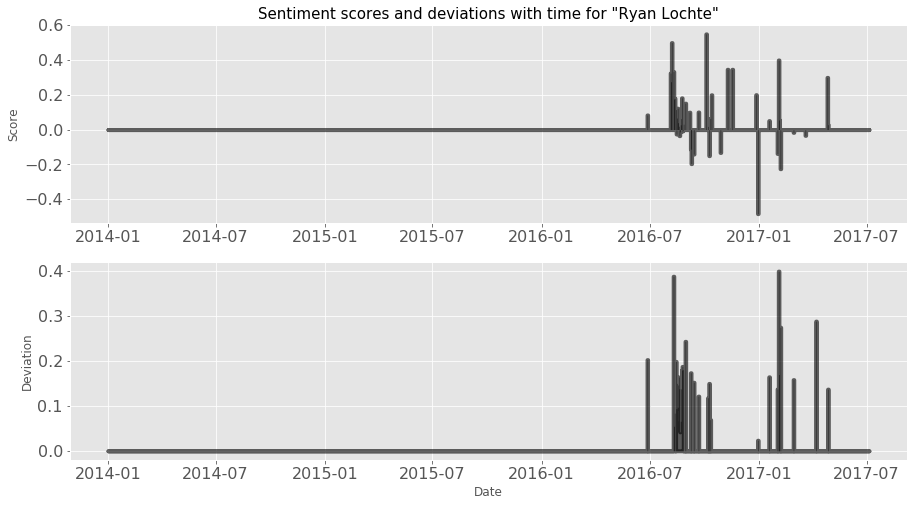

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.fill_between(scores_daily.index, scores_daily['score'], step='mid', 
                 color='black', alpha=0.6, linewidth=4,
                );
ax1.set_ylabel('Score');
ax1.set_title('Sentiment scores and deviations with time for "{}"'.format(name), size=15);
ax2.fill_between(scores_daily.index, scores_daily['deviation'], step='mid', color='black', alpha=0.6, linewidth=4);
ax2.set_ylabel('Deviation');
ax2.set_xlabel('Date');
# plt.savefig("{}_scores".format('_'.join(name.split()).lower()))

 #### Make calendar plot to show periods of activity

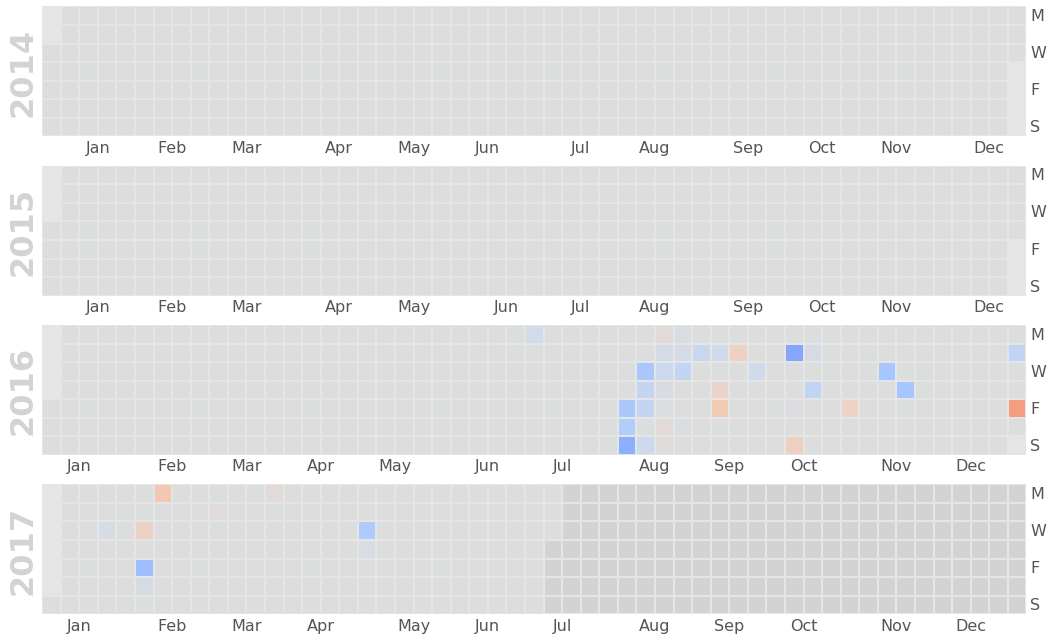

In [40]:
calmap.calendarplot(scores_daily['score'],
                    vmin = -1.0,
                    vmax=1.0,
                    daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    fig_kws=dict(figsize=(15, 9)),
                    linewidth=1,
                    fillcolor='lightgrey',
                    cmap='coolwarm_r',
                   );

#### Get counts of positive and negative mentions based on Publication

In [31]:
grouped = news_relevant.groupby('publication').apply(lambda x: x['score'] >= 0.0)
grouped = grouped.groupby('publication').value_counts().to_frame()
grouped = grouped.unstack().fillna(0.0)
grouped.columns = ['Negative', 'Positive']
grouped = grouped.sort_values(by='Negative')
grouped

,Negative,Positive
publication,,
Los Angeles Times,0.0,2.0
National Review,0.0,7.0
Reuters,0.0,4.0
Business Insider,2.0,4.0
New York Post,2.0,10.0
Atlantic,3.0,16.0
Breitbart,3.0,4.0
Fox News,4.0,8.0
NPR,4.0,9.0


#### Plot article breakdown

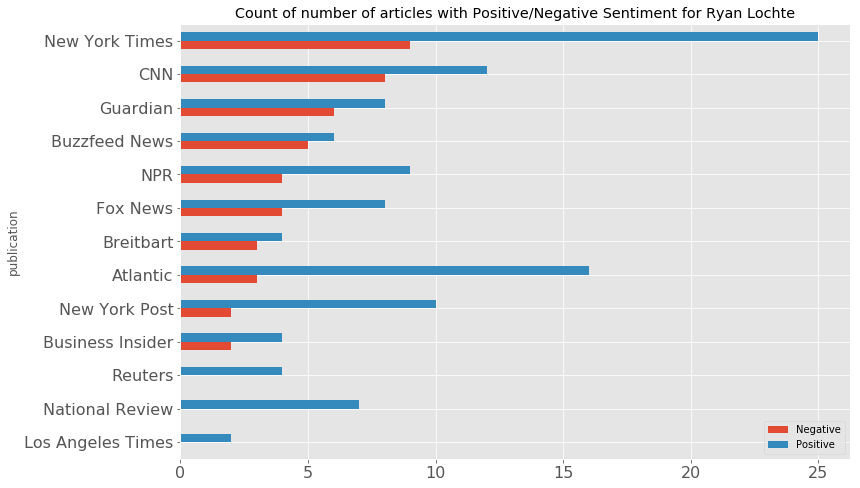

In [32]:
grouped.plot(kind='barh', figsize=(12, 8));
plt.title('Count of number of articles with Positive/Negative Sentiment for {}'.format(name));
# plt.savefig("{}_breakdown".format('_'.join(name.split()).lower()))

#### Output result to CSV

In [33]:
out_filename = '_'.join(name.split()).lower() + '_breakdown.csv'
out_path = Path('./') / "results/textblob" / out_filename
grouped.to_csv(out_path, index=False, header=True)

## Visualize Cosine Similarity Distances
To see how similar or different each article is based on publication, we can compute the cosine distances between articles to generate a "distance matrix" and then visualize these distances in two-dimensional space.

#### Calculate TF-IDF for document similarity
We first define the term frequency-inverse document frequency to vectorize the text for each article into parameters, and generate a ```tf-idf``` matrix. 

Once we compute the ```tf-idf``` matrix, we can find a "distance matrix" that stores how similar or how different two documents are.

In [34]:
# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2)
# 
tfidf_matrix = tfidf_vectorizer.fit_transform(news_relevant['lemmas_combined'] ) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

# Display some key terms
terms = tfidf_vectorizer.get_feature_names()

(161, 37)


In [35]:
# Get cosine distance matrix
dist = 1 - cosine_similarity(tfidf_matrix)

#### Multidimensional Scaling (MDS)
The computed distances are in multi-dimensional in nature. To visualize the similarity, we "embed" the cosine distances (from the distance matrix) to a two-dimensional space, which we can then plot to see how the articles compare with each other in terms of their content.

In [36]:
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=37)
dist_transformed = embedding.fit_transform(dist)
print(dist_transformed.shape)

xs, ys = dist_transformed[:, 0], dist_transformed[:, 1]

(161, 2)


#### Generate an MDS DataFrame for plotting
We combine the x-y distances from the MDS calculation with the original publication labels to see how different the articles are from each other, colored by publication.

In [37]:
compare = pd.DataFrame(dict(label=news_relevant['publication'], x=xs, y=ys))
compare.head()

,label,x,y
3095,Los Angeles Times,0.049449,0.029639
8946,Los Angeles Times,0.035553,-0.470827
13789,New York Times,0.569741,-0.192691
13825,New York Times,0.679005,0.406072
13839,New York Times,-0.364867,0.741446


In [38]:
L = news_relevant['publication'].nunique()
print("Found {} unique categories for publications".format(L))

Found 13 unique categories for publications


#### Visualize similarities as embedded cosine distances

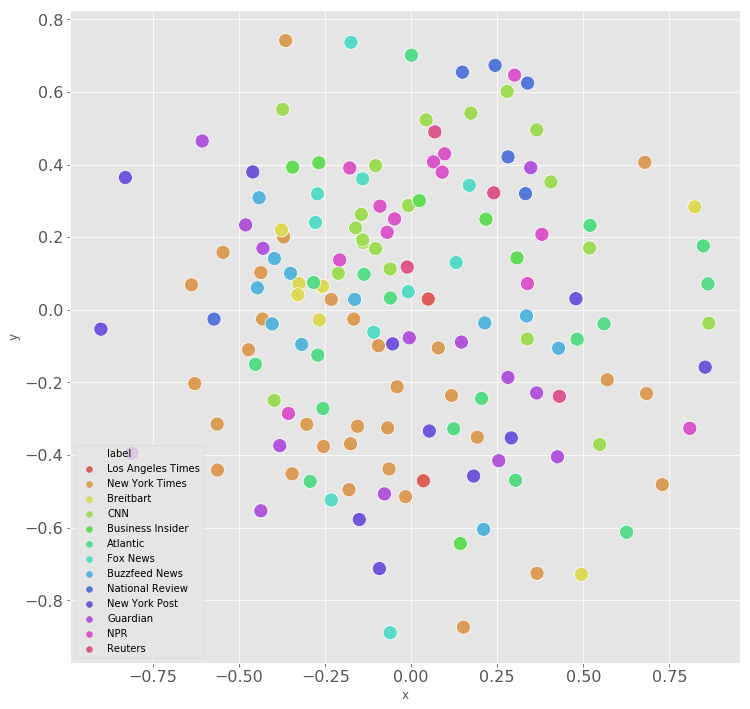

In [39]:
plt.figure(figsize=(12, 12))
sns.scatterplot(x='x', y='y', data=compare, hue='label',
               s=200, palette=sns.color_palette("hls", 13));
plt.legend(loc='best');